# Additional Analysis: PCA
This notebook aims to answer the question if all the 1900 features learned by eUniRep are really necessary, or if we can reduce the dimensionality and get better results. We also visualize the data using PCA and t-SNE.

In [1]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install optuna
!pip install biopython
!pip install seaborn

  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-1owftt4t
  Running command git clone -q https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-1owftt4t
  Created wheel for jax-unirep: filename=jax_unirep-0.1-cp36-none-any.whl size=67744670 sha256=acf1d915f94e23e5919dbca57490ac716885952d3a97c40187b4ca806572a978
  Stored in directory: /tmp/pip-ephem-wheel-cache-3_s35pt5/wheels/08/4d/ac/6e75862c118d1ad82122f410859524b20190ce7a821b76ffcd
Successfully built jax-unirep
     |████████████████████████████████| 184kB 9.7MB/s 
     |████████████████████████████████| 1.1MB 21.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 112kB 4

In [2]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params_1900
from Bio import SeqIO
import pandas as pd
import glob
import os
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import feather

from google.colab import drive

drive.mount('/content/drive/')
gdrive_path = "/content/drive/My Drive/Colab Notebooks/UniRep2/"
!ls "/content/drive/My Drive/Colab Notebooks/UniRep2"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
2MS2_weights  feathers	pca_analysis.ipynb  top_training.ipynb
BLAC_weights  inputs	PETase_weights


In [0]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(gdrive_path + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data

# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(name):
    seqs = np.loadtxt(gdrive_path + name + '_seqs.txt', dtype='str')
    
    fitnesses = np.loadtxt(gdrive_path + name + '_fitness.txt')
    data = []
    for seq, fitness in zip(seqs, fitnesses):
        data.append([str(seq).strip(), fitness])
    
    return data

# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


aa_to_int = {
  'M':1,
  'R':2,
  'H':3,
  'K':4,
  'D':5,
  'E':6,
  'S':7,
  'T':8,
  'N':9,
  'Q':10,
  'C':11,
  'U':12,
  'G':13,
  'P':14,
  'A':15,
  'V':16,
  'I':17,
  'F':18,
  'Y':19,
  'W':20,
  'L':21,
  'O':22, #Pyrrolysine
  'X':23, # Unknown
  'Z':23, # Glutamic acid or GLutamine
  'B':23, # Asparagine or aspartic acid
  'J':23, # Leucine or isoleucine
  'start':24,
  'stop':25,
}


def get_int_to_aa():
  return {value:key for key, value in aa_to_int.items()}


def _one_hot(x, k, dtype=np.float32):
  # return np.array(x[:, None] == np.arange(k), dtype)
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def distance_matrix(N):
	distance_matrix = np.zeros((N,N))
	for i in range(N):
		for j in range(N):
			# distance_matrix[i,j]=1- ((abs(i-j)/N)**2)
			distance_matrix[i,j]= 1-(abs(i-j)/N)

	return distance_matrix


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)
  # dist_mat = distance_matrix(N)
  # confusion_matrix = confusion_matrix*dist_mat
  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

###Load Reps
Load representations of sequences stored in .feather format, then use those representations and corresponding labels to train a top model.

In [0]:
# load the reps you want into dataframes
FEATHER_PATH = gdrive_path + 'feathers/'

unirep_df = read_reps(FEATHER_PATH + 'BLAC_unirep')
eunirep_df = read_reps(FEATHER_PATH + 'BLAC_eunirep')
onehot_df = read_reps(FEATHER_PATH + 'BLAC_one_hot')

dfs = [unirep_df, eunirep_df, onehot_df]
df_names = ['unirep', 'eunirep', 'one hot']

#### 3-Component PCA visualized
First lets visualize what the 3 component PCA's look like

unirep explained variation per PC: [0.686026   0.24962017 0.03395827]
eunirep explained variation per PC: [0.91268444 0.02035035 0.0165777 ]
one hot explained variation per PC: [0.00820098 0.00819354 0.00818871]


<Figure size 432x288 with 0 Axes>

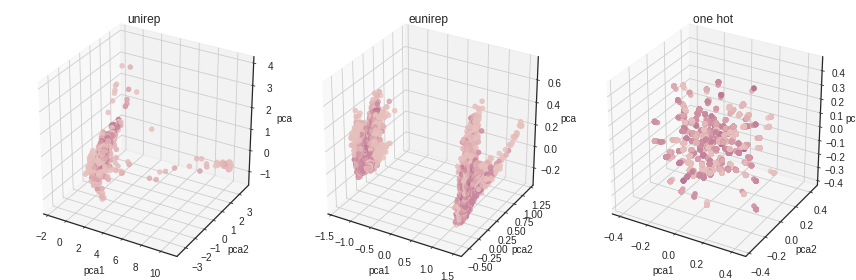

In [21]:
N_COMPS = 1000

plt.clf()
fig = plt.figure(figsize=(4*len(dfs),4))
plt.style.use('seaborn-white')

for i in range(len(dfs)):
  pca = PCA(n_components=N_COMPS)
  pca_result = pca.fit_transform(dfs[i][dfs[i].columns[2:]].values)
  dfs[i]['pca1'] = pca_result[:,0]
  dfs[i]['pca2'] = pca_result[:,1] 
  dfs[i]['pca3'] = pca_result[:,2]
  print(df_names[i], 'explained variation per top 3 PC: {}'.format(pca.explained_variance_ratio_[0:3]))

  ax = fig.add_subplot(1,len(dfs),(i+1), title=df_names[i], projection="3d")
  ax.scatter(
      xs=dfs[i]["pca1"], 
      ys=dfs[i]["pca2"], 
      zs=dfs[i]["pca3"], 
      c=dfs[i]["fitness"],
      cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
      alpha=0.8
  )

  ax.set_xlabel('pca1')
  ax.set_ylabel('pca2')
  ax.set_zlabel('pca3')


plt.tight_layout()
plt.show()


#### Top model training on N-component PCAs
We're now going to try varying the N-components used and comparing peformance to the full unirep, eunirep and one-hot representations.

unirep [0.3076923076923077, 0.6349206349206349, 1.5217391304347827, 0.5309734513274336, 0.631578947368421, 1.0526315789473684, 0.6956521739130435, 0.6956521739130435, 0.7619047619047619, 0.5063291139240506, 0.0, 0.25641025641025644, 0.6, 0.9708737864077669, 0.8791208791208791, 1.0169491525423728, 0.8759124087591241, 0.6593406593406593, 0.23529411764705882, 0.9876543209876544] Mean Score: 0.691031492778081
unirep PCA comps: 10 Mean Score: 0.6338502541531136
unirep PCA comps: 50 Mean Score: 0.6338502541531136
unirep PCA comps: 100 Mean Score: 0.6338502541531136
unirep PCA comps: 500 Mean Score: 0.6338502541531136
unirep PCA comps: 1000 Mean Score: 0.6338502541531136
eunirep [2.0, 1.4285714285714286, 1.956521739130435, 2.1238938053097343, 1.263157894736842, 2.631578947368421, 1.0434782608695652, 1.2173913043478262, 1.5238095238095237, 1.2658227848101264, 0.8163265306122448, 1.794871794871795, 1.4, 1.3592233009708736, 1.3186813186813187, 1.8644067796610169, 1.1678832116788322, 0.8791208791

<Figure size 432x288 with 0 Axes>

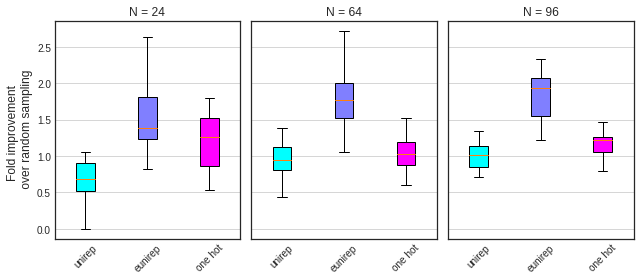

In [31]:
# regularization hyperparameters
ALPHAS = [0.01, 0.01, 0.1]

# number of batches to test
N_BATCH = 20

# number of sequences per training batch
TRAIN_BATCH_SIZES = [24, 64, 96]

# number of random trials to perform for baseline
N_RAND_BATCHES = 20

# wild-type fitness
WT_FIT = 1

# components for PCA
N_COMPS=[10,50,100,500,1000]

batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:

  # of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:1901]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:1901]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = RidgeCV(alphas=[ALPHAS[j]], cv=kfold)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    params_level.append(scores_level)
    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))

    # ADD PCAs:
    for n_comp in N_COMPS:
      pca_score_level = []
      for i in range(N_BATCH):
        # change random seed for each batch
        np.random.seed(42*(i+2))
        rndperm = np.random.permutation(df.shape[0])

        # data setup
        X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[1901:(1901+n_comp)]]
        Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

        X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[1901:(1901+n_comp)]]
        Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

        # ridge regression model setup
        kfold = KFold(n_splits=10, shuffle=True)

        model = RidgeCV(alphas=[ALPHAS[j]], cv=kfold)

        # fit the model
        model.fit(X, Y)

        # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
        Y_preds = model.predict(X_holdout)

        usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

        # Note: wild-type fitness = WT_FIT (thats the scoring metric)
        usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

        # randomly shuffle holdout set RAND_BATCHES time
        # and take average of top TRAIN_BATCH_SIZE fitness
        avg_rand_count = 0
        for k in range(N_RAND_BATCHES):
          np.random.seed(42*(i+2) + (1+k))
          rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
          avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
        avg_rand_count /= N_RAND_BATCHES

        # final score ratio:
        pca_score_level.append(usorted_count/avg_rand_count)

      print(df_names[j], 'PCA comps:', n_comp, "Mean Score:", np.mean(pca_score_level))


  batch_level.append(params_level)

plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()


Our results show for this particular dataset that for all unirep and eunirep trials PCA dimensionality reduction reduces top model performance, whereas the only single instance of PCA (almost negigibly) improving performance is in the one-hot encodings for N=96 with all 1000 principal components used.

#### t-SNE visualizations
We can try do t-SNE visualizations on our datasets as well. 

In [38]:
eunirep_df = dfs[1]

tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=9000)
tsne_results = tsne.fit_transform(eunirep_df[eunirep_df.columns[1901:1921]].values)
eunirep_df['tsne-2d-1'] = tsne_results[:,0]
eunirep_df['tsne-2d-2'] = tsne_results[:,1]

plt.clf()
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(1,1,1, title="eUniRep")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax1,
    #alpha=0.3
)

plt.tight_layout()
plt.show()


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5469 samples in 0.009s...
[t-SNE] Computed neighbors for 5469 samples in 0.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5469
[t-SNE] Computed conditional probabilities for sample 2000 / 5469
[t-SNE] Computed conditional probabilities for sample 3000 / 5469
[t-SNE] Computed conditional probabilities for sample 4000 / 5469
[t-SNE] Computed conditional probabilities for sample 5000 / 5469
[t-SNE] Computed conditional probabilities for sample 5469 / 5469
[t-SNE] Mean sigma: 2.587938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.957130


KeyboardInterrupt: ignored